# ITD214 Project - Singapore MRT Passenger Experience (Dynamic Topic Modeling)

## BRYAN CHEW 5168113F

This is an implementation of dynamic topic modeling in python.
<br>From Wikipedia, the free encyclopedia:
<br>Within statistics, Dynamic topic models are generative models that can be used to analyze the evolution of (unobserved) topics of a collection of documents over time.

## 1. Business Understanding
Singapore Public Transport Council (PTC) completed a survey in Apr 2024.
<br>*Data Source: https://www.ptc.gov.sg/newsroom/news-releases/newsroom-view/ptc-s-survey-findings-on-customers--satisfaction-with-public-transport*

Commuters feel that train reliability is the most important service component to them, followed by travel time and then next is safety/security.

Business Objective = Improve the commuter experience of the Singapore MRT system

Data mining goal: To identify the factors contributing to MRT train reliability

## 2. Data Understanding
Collect initial Data by using webscrapper (eg Parsehub)
<br>Data Collection Sources:
<br>- Local news websites (Straits Times, CNA, Mothership, AsiaOne, Today, Independent Singapore, Yahoo News, STOMP, SG Carmart)
<br>- Malaysia news websites (The Star, Malay Mail)

Exploratory Data Analysis (EDA) was carried out.

### Install relevant libraries and packages
Do the pip install only if not installed previously to the environment.

In [2]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install gensim

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install selenium

   ---------------------------------------- 0.0/9.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.4 MB ? eta -:--:--
    --------------------------------------- 0.2/9.4 MB 1.8 MB/s eta 0:00:06
    --------------------------------------- 0.2/9.4 MB 1.7 MB/s eta 0:00:06
   ----- ---------------------------------- 1.2/9.4 MB 5.8 MB/s eta 0:00:02
   ------ --------------------------------- 1.6/9.4 MB 7.4 MB/s eta 0:00:02
   ------ --------------------------------- 1.6/9.4 MB 7.4 MB/s eta 0:00:02
   ------ --------------------------------- 1.6/9.4 MB 7.4 MB/s eta 0:00:02
   ------- -------------------------------- 1.8/9.4 MB 4.5 MB/s eta 0:00:02
   ----------- ---------------------------- 2.6/9.4 MB 6.4 MB/s eta 0:00:02
   ----------- ---------------------------- 2.6/9.4 MB 6.4 MB/s eta 0:00:02
   ------------ --------------------------- 2.9/9.4 MB 5.7 MB/s eta 0:00:02
   ------------ -----------------

In [2]:
# Standard Library Imports
import os
import sys
import re
import json
import string
from pathlib import Path
from datetime import datetime
from collections import defaultdict, Counter
import itertools
import functools

# Data Handling
import pandas as pd
import numpy as np

# NLTK Imports
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')

# Gensim Imports
import gensim
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from gensim.parsing.porter import PorterStemmer
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models.ldaseqmodel import LdaSeqModel
from gensim.models.coherencemodel import CoherenceModel

# Misc Imports
from pprint import pprint
from wordcloud import WordCloud

# pyLDAvis Imports
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Tensorflow Imports
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow.keras as keras

# Scikit-learn Imports
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Matplotlib Imports
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# Plotly Imports
import plotly.graph_objects as go
import plotly.express as px

# Seaborn Imports
import seaborn as sns

# Selenium Imports
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options

# Set warnings filter
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Exploratory Data Analysis (EDA)
The documents were loaded into a dataframe for exploration.

(504, 2)


Review  year
0  Signalling fault causes delays on Downtown Lin...  2018
1  Preparatory work to connect Thomson-East Coast...  2024
2  Smart Maintenance via Dynamic Fault Tree Analy...  2017
3  Disconnect between public and operator’s ideas...  2014
4  SMRT’s rail revenue up 10.4% from pre-Covid-19...  2023

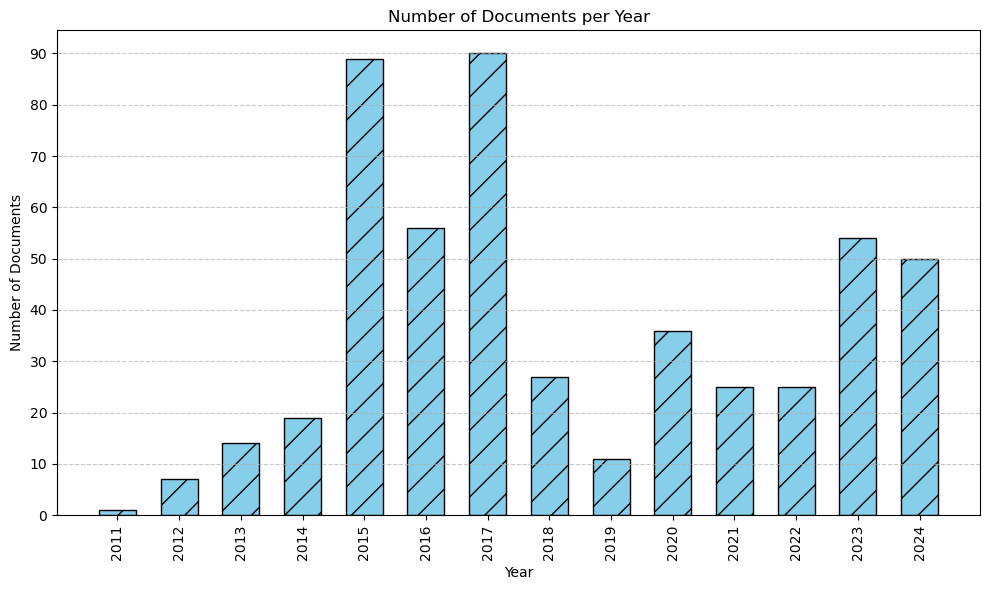

In [25]:
# Specify the folder containing text files
folder_path = './ProjectData'

file_contents = []
file_year = []

for file_name in os.listdir(folder_path):
    if file_name.endswith('.txt'):
        year = '20' + file_name[6:8]
        file_year.append(year)
        
        # Construct full file path
        file_path = os.path.join(folder_path, file_name)
        # Read the text file content
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
            # Append the content to the list
            file_contents.append(content)

# Create a DataFrame from the list of contents
df = pd.DataFrame({'Review': file_contents, 'year': file_year})

print(df.shape)

# Set display option to show max 50 chars
pd.set_option('display.max_colwidth', 50)

# Show the first five rows of the DataFrame
display(df.head())

# Count the number of documents per year
document_counts = df['year'].value_counts().sort_index()

# Plot document distribution over the years
plt.figure(figsize=(10, 6))
plt.bar(document_counts.index, document_counts.values, color='skyblue', edgecolor='black', width=0.6, hatch='/')
plt.xlabel('Year')
plt.ylabel('Number of Documents')
plt.title('Number of Documents per Year')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.gca().yaxis.set_major_locator(MultipleLocator(10))
plt.grid(axis='y', which='major', linestyle='--', alpha=0.7) # Grid lines 70% opaque for visibility of the bars
plt.tight_layout()

# Show the plot
plt.show()

## 3. Data Preparation
Data was cleaned and formatted to the suitable structure.

At first stemming was attempted, but the results shown was not very comprehensible for many words (eg delai, preparatori, strai, dynam)
<br>So this method was ignored later.

In [4]:
# Attempt at using Stemming
stemmer = PorterStemmer()

# Function to apply stemming
def stem_text(text):
    words = nltk.word_tokenize(text)
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

# Apply stemming to the 'Review' column of the data
df['StemmedReview'] = df['Review'].apply(stem_text)

df[['Review', 'StemmedReview']].head(10)

# Note Stemming was ignored later as the process distorted the orginal key words in each document significantly.

Review  \
0  Signalling fault causes delays on Downtown Lin...   
1  Preparatory work to connect Thomson-East Coast...   
2  Smart Maintenance via Dynamic Fault Tree Analy...   
3  Disconnect between public and operator’s ideas...   
4  SMRT’s rail revenue up 10.4% from pre-Covid-19...   
5  Singapore’s MTR Transit System Breakdowns\n\n\...   
6  Stray current monitoring and control on Singap...   
7  Renewing the North-South and East-West MRT lin...   
8  Signalling fault causes 30-minute train delay ...   
9  First of 19 new Bukit Panjang LRT trains being...   

                                       StemmedReview  
0  signal fault caus delai on downtown line in bo...  
1  preparatori work to connect thomson-east coast...  
2  smart mainten via dynam fault tree analysi : a...  
3  disconnect between public and oper ’ s idea of...  
4  smrt ’ s rail revenu up 10.4 % from pre-covid-...  
5  singapor ’ s mtr transit system breakdown http...  
6  strai current monitor and control on singapor ...  
7  renew the north-south and east-west mrt line w...  
8  signal fault caus 30-minut train delai between...  
9  first of 19 new bukit panjang lrt train be tes...

### Preprocessing text
The function to clean the data, including lemmatization.
<br> Note that the list of custom_stop_words are by reviewing the list of common words in later steps and then adjusted here (iterative approach).
<br> Words of little significance for the analysis were added to the list of custom stop words. 

In [5]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Define stopwords
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if not isinstance(text, str):  # Check if text is a string
        return ''  # Return empty string if not a string
    text = text.lower()    # lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)    # Remove @urls
    text = re.sub(r'\@\w+|\#','', text)    # Remove @username and #hashtags
    text = re.sub(r'&amp', '', text)    # Remove &amp
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation
    
    # Custom stopwords for control
    custom_stop_words = {
        "said", "say", "smrt", "mrt", "u", "m","mr","st","even","also","would","could","transport","singapore",
        "need","wayang","one","two","three","four","five","train","per","yio","train", "bus",
        "year", "train", "public", "commuter", "faisal","air", "like", "occurred", "quite", "include", 
        "stomper", "min", "station", "chee", "news", "people", "resignation", "problem", "wrote", "due", "transit", 
        "reliability", "percentage", "week", "saw", "incident", "responsibility", "line", "tan", "bus", "take", "new",
        "top", "mean", "million", "delay", "minute", "ltd", "railway", "delay", "commute","ha", "wa","retail", "artwork", 
        "artist", "piece","satisfaction", "thought","time","service", "show", "seen", "hour", "first",
        "added", "caused", "still", "get", "well", "around","many","made","along","cause","since", "another", "issue", "tata","doe"
        }
    stop_words.update(custom_stop_words)
    
    # Split and tokenize
    words = text.split()  
    
    # Lemmatization
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    
    cleaned_words = [word for word in lemmatized_words if word not in stop_words]
    
    return cleaned_words

### Reading in the documents data and apply the preprocessing/cleaning step
Add the function to read the data and also to clean it.

In [6]:
def read_documents(folder_path):
    documents = defaultdict(list)
    processed_docs = defaultdict(list)  # Store processed documents for coherence calculation
    
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            
            year = '20' + filename[6:8]

            with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
                text = file.read()
                processed_text = preprocess_text(text)
                documents[year].append(processed_text)
                processed_docs[year].append(processed_text)
    return documents, processed_docs

### Plot top 50 word frequency and word cloud


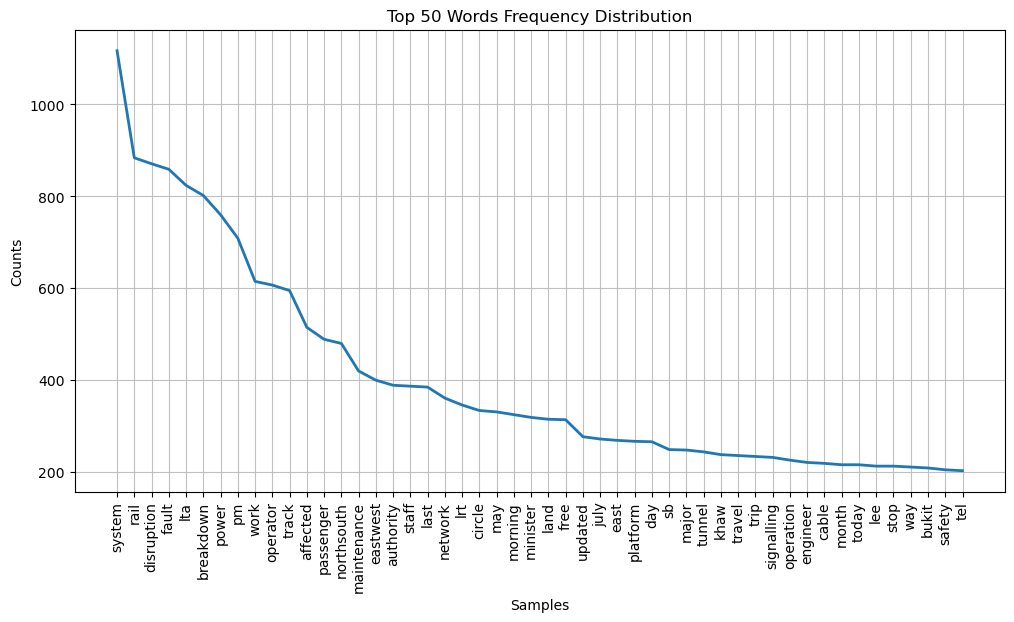

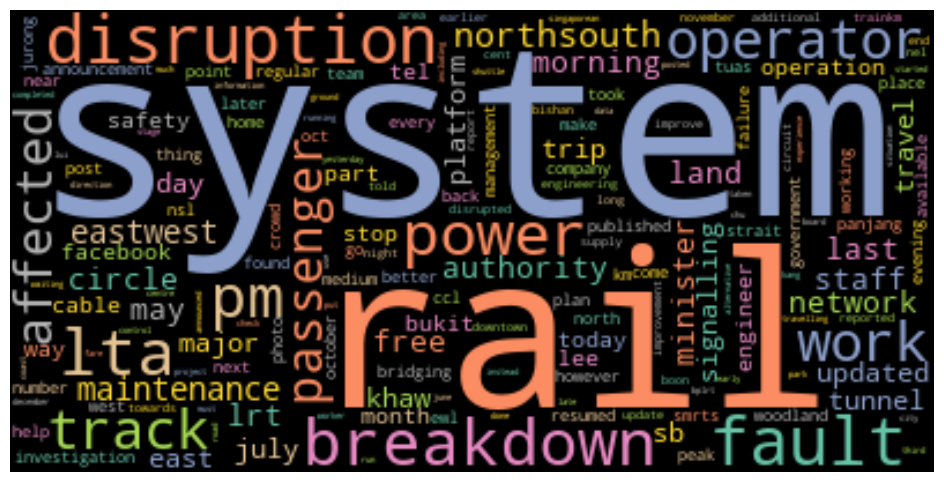

In [26]:
def plot_word_frequency_cloud(processed_docs):
    all_words = []
    for year in processed_docs:
        for doc in processed_docs[year]:
            all_words.extend(doc)
    
    word_freq = Counter(all_words)
    
    # Calculate frequency distribution
    freq_dist = FreqDist(all_words)
    
    # Plot top 50 words frequency distribution
    plt.figure(figsize=(12, 6))
    fq = freq_dist.plot(50, title='Top 50 Words Frequency Distribution', cumulative=False)
    plt.show()

    # Generate a word cloud
    wordcloud = WordCloud(colormap='Set2', collocations=False).generate_from_frequencies(freq_dist)
    
    # Plot the word cloud
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()


folder_path = './ProjectData'    # raw data stored in folder

# Read documents and preprocess
documents, processed_docs = read_documents(folder_path)

# Plot word frequency distribution
plot_word_frequency_cloud(processed_docs)

## 4. Modelling
Dynamic Topic Modelling was carried out.

### Determine best hypertune parameters alpha (document-topic distribution) and beta (topic-word distribution)

In [8]:
# Build dictionary and corpus from documents
def create_dictionary_and_corpus(docs):
    all_words = [word for doc in docs for word in doc]
    dictionary = corpora.Dictionary([all_words])
    corpus = [dictionary.doc2bow(doc) for doc in docs]
    return dictionary, corpus

# Function evaluates the coherence and perplexity scores for the model
def evaluate_model(lda_model, docs, dictionary, corpus):
    coherence_model = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    perplexity_score = lda_model.log_perplexity(corpus)
    return coherence_score, perplexity_score

Different values of alpha and beta were passed into the function to generate coherence and perplexity scores. 
We shall use highest coherence scores to determine the best model.

In [20]:
# Set a random seed for reproducibility
np.random.seed(105)

def evaluate_lda_model(documents, num_topics=10, passes=10, alpha='symmetric', beta=None):
    models, dictionaries, coherence_scores, perplexity_scores = {}, {}, {}, {}

    for year, docs in sorted(documents.items()):
        dictionary, corpus = create_dictionary_and_corpus(docs)
        lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=passes, alpha=alpha, eta=beta, random_state=100)
        coherence_scores[year], perplexity_scores[year] = evaluate_model(lda_model, docs, dictionary, corpus)

    avg_coherence = np.mean(list(coherence_scores.values()))
    avg_perplexity = np.mean(list(perplexity_scores.values()))

    return avg_coherence, avg_perplexity


def search_alpha_beta(documents, alpha_values, beta_values, num_topics=10, passes=10):
    best_coherence, cores_perplexity = -np.inf, np.inf    # cores_perplexity: corresponding perpleixty for best coherence
    best_params = {'alpha': None, 'beta': None}

    for alpha in alpha_values:
        for beta in beta_values:
            avg_coherence, avg_perplexity = evaluate_lda_model(documents, num_topics, passes, alpha, beta)

            if avg_coherence > best_coherence:
                best_coherence, cores_perplexity = avg_coherence, avg_perplexity
                best_params['alpha'], best_params['beta'] = alpha, beta

    return best_params, best_coherence, cores_perplexity

# Search for best alpha and beta
alpha_values = ['symmetric', 'asymmetric', 0.01, 0.10]
beta_values = [None, 'symmetric', 0.01, 0.10]
best_params, best_coherence, cores_perplexity = search_alpha_beta(documents, alpha_values, beta_values)

print(f"Best parameters: alpha={best_params['alpha']}, beta={best_params['beta']}")
print(f"Best average coherence score: {best_coherence}")
print(f"Corresponding average perplexity score: {cores_perplexity}")    # cores_perplexity: corresponding perpleixty for best coherence

Best parameters: alpha=symmetric, beta=None
Best average coherence score: 0.43920616988914274
Corresponding average perplexity score: -7.236271043514942


We shall adjust alpha='auto' and beta=None for the rest of the model steps below.

In [9]:
# standard model with alpha and beta values pre-defined
def dynamic_topic_modeling(documents, num_topics=10, passes=10, alpha='auto', beta=None):
    models, dictionaries = {}, {}

    for year, docs in sorted(documents.items()):
        dictionary, corpus = create_dictionary_and_corpus(docs)
        dictionaries[year] = dictionary
        lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=passes, alpha=alpha, eta=beta, random_state=100)
        models[year] = lda_model

    return models, dictionaries

### Determine best number of topics parameter
The number of topics parameter num_topics is incrementally changed and the best coherence score will result in the best model.

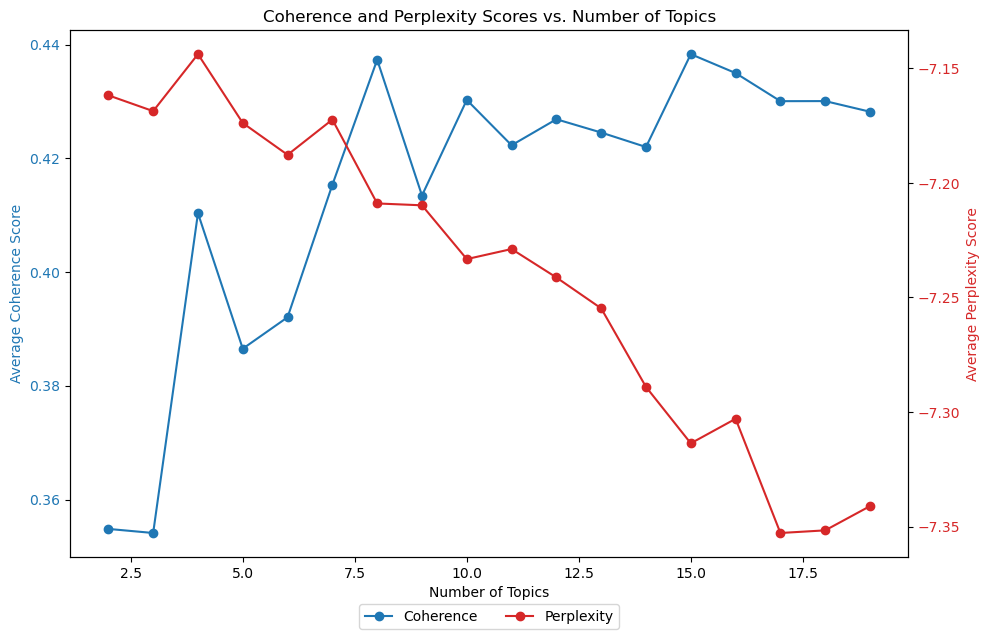

In [27]:
def compute_coherence_scores(models, processed_docs, dictionaries):
    coherence_scores = {}
    for year, model in models.items():
        dictionary = dictionaries[year]
        coherence_model = CoherenceModel(model=model, texts=processed_docs[year], dictionary=dictionary, coherence='c_v')
        coherence_scores[year] = coherence_model.get_coherence()
    return coherence_scores

def compute_perplexity_scores(models, dictionaries, processed_docs):
    perplexity_scores = {}
    for year, model in models.items():
        dictionary = dictionaries[year]
        corpus = [dictionary.doc2bow(doc) for doc in processed_docs[year]]
        perplexity_scores[year] = model.log_perplexity(corpus)
    return perplexity_scores

def evaluate_topic_numbers(documents, processed_docs, num_topics_range, passes=10):
    coherence_scores, perplexity_scores = {}, {}

    for num_topics in num_topics_range:
        models, dictionaries = dynamic_topic_modeling(documents, num_topics=num_topics, passes=passes)
        coherence_scores[num_topics] = np.mean(list(compute_coherence_scores(models, processed_docs, dictionaries).values()))
        perplexity_scores[num_topics] = np.mean(list(compute_perplexity_scores(models, dictionaries, processed_docs).values()))

    return coherence_scores, perplexity_scores

def plot_test_scores(coherence_scores, perplexity_scores):
    num_topics = list(coherence_scores.keys())
    coherence = list(coherence_scores.values())
    perplexity = [perplexity_scores[nt] for nt in num_topics]

    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    color = 'tab:blue'
    ax1.set_xlabel('Number of Topics')
    ax1.set_ylabel('Average Coherence Score', color=color)
    line1, = ax1.plot(num_topics, coherence, marker='o', linestyle='-', color=color, label='Coherence')
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Average Perplexity Score', color=color)
    line2, = ax2.plot(num_topics, perplexity, marker='o', linestyle='-', color=color, label='Perplexity')
    ax2.tick_params(axis='y', labelcolor=color)
    
    fig.tight_layout()
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=2)
    plt.title('Coherence and Perplexity Scores vs. Number of Topics')
    plt.show()

# Evaluate best number of topics
num_topics_range = range(2, 20)
test_coherence_scores, test_perplexity_scores = evaluate_topic_numbers(documents, processed_docs, num_topics_range)
plot_test_scores(test_coherence_scores, test_perplexity_scores)

## 5. Evaluation
An optimal value for number of topics is 8 as it shows the highest coherence score before the coherence curve plateau.
<br>On the perplexity curve, the number of topics 8 also concides when the curve first starts to flatten out locally.

As a check we plot the coherence and perplexity scores over the years to see if stable.

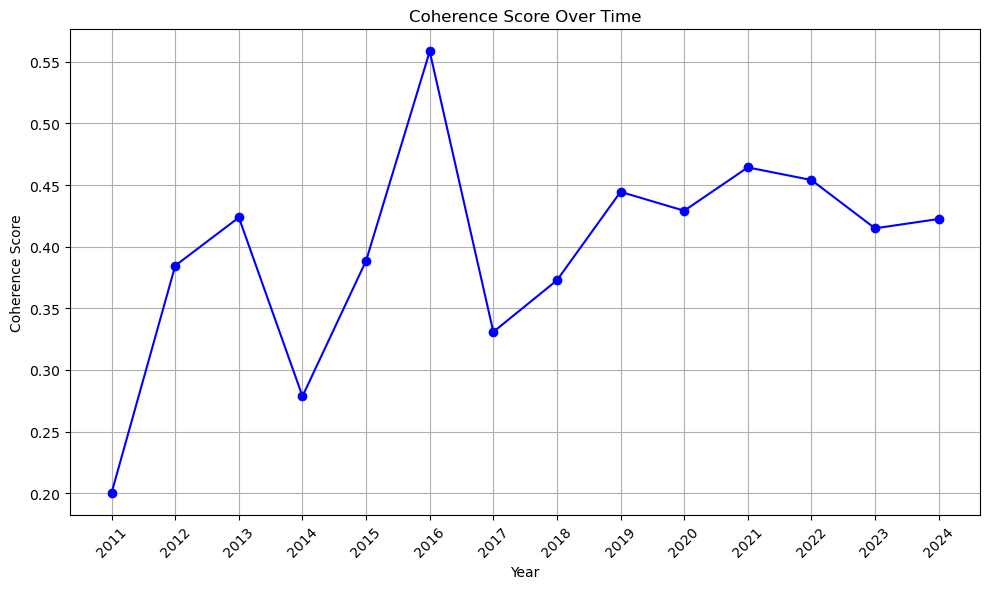

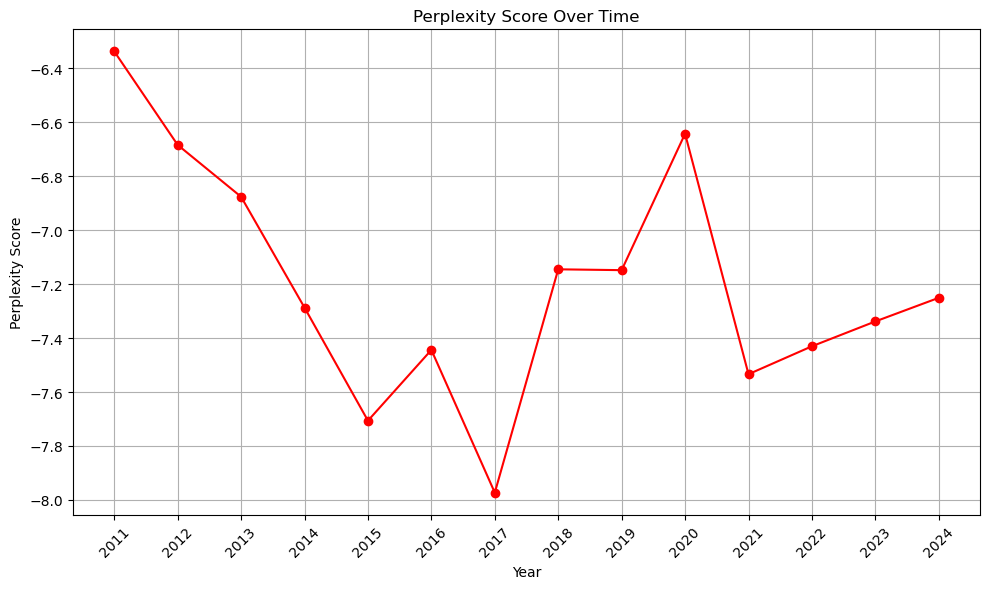

In [10]:
def plot_scores_over_time(scores, ylabel, title, color='b'):
    years = list(scores.keys())
    score_values = list(scores.values())
    
    plt.figure(figsize=(10, 6))
    plt.plot(years, score_values, marker='o', linestyle='-', color=color)
    plt.xlabel('Year')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def compute_and_plot_scores(models, processed_docs, dictionaries, score_type='coherence'):
    scores = {}
    for year, model in models.items():
        dictionary = dictionaries[year]
        corpus = [dictionary.doc2bow(doc) for doc in processed_docs[year]]

        if score_type == 'coherence':
            coherence_model = CoherenceModel(model=model, texts=processed_docs[year], dictionary=dictionary, coherence='c_v')
            score = coherence_model.get_coherence()
        else:  # perplexity
            score = model.log_perplexity(corpus)

        scores[year] = score

    ylabel = f"{score_type.capitalize()} Score"
    title = f"{score_type.capitalize()} Score Over Time"
    plot_scores_over_time(scores, ylabel, title, color='b' if score_type == 'coherence' else 'r')


# reload the documents and run the model with the revised parameters (eg num_topics, alpha, beta)
documents, processed_docs = read_documents(folder_path)
models, dictionaries = dynamic_topic_modeling(documents, num_topics=8, passes=10, alpha='auto', beta=None)

# Plot separate coherence and perplexity scores over the years
compute_and_plot_scores(models, processed_docs, dictionaries, score_type='coherence')
compute_and_plot_scores(models, processed_docs, dictionaries, score_type='perplexity')

On the whole, the coherence scores are stable with no sudden exceptional dips.

### Show summary for topics and changes over the years

In [11]:
# Shows the topics for each year, limiting to 10 term words per year
def display_topics_over_time(models):
    for year, model in models.items():
        print(f"\nTopics for {year}:")
        for idx, topic in model.print_topics(num_topics=-1, num_words=10):
            print(f"Topic {idx}: {topic}")

display_topics_over_time(models)


Topics for 2011:
Topic 0: 0.024*"management" + 0.020*"team" + 0.012*"business" + 0.012*"network" + 0.012*"system" + 0.012*"breakdown" + 0.012*"response" + 0.008*"local" + 0.008*"unfortunately" + 0.008*"competency"
Topic 1: 0.006*"management" + 0.006*"team" + 0.006*"response" + 0.006*"minister" + 0.006*"network" + 0.006*"breakdown" + 0.006*"business" + 0.006*"appease" + 0.006*"system" + 0.006*"plot"
Topic 2: 0.006*"management" + 0.006*"team" + 0.006*"network" + 0.006*"response" + 0.006*"system" + 0.006*"organisation" + 0.006*"business" + 0.006*"getting" + 0.006*"head" + 0.006*"stream"
Topic 3: 0.006*"management" + 0.006*"team" + 0.006*"response" + 0.006*"system" + 0.006*"breakdown" + 0.006*"network" + 0.006*"business" + 0.006*"actor" + 0.006*"head" + 0.006*"lost"
Topic 4: 0.006*"team" + 0.006*"management" + 0.006*"business" + 0.006*"system" + 0.006*"response" + 0.006*"technocratic" + 0.006*"network" + 0.006*"breakdown" + 0.006*"current" + 0.006*"focus"
Topic 5: 0.006*"management" + 0.0

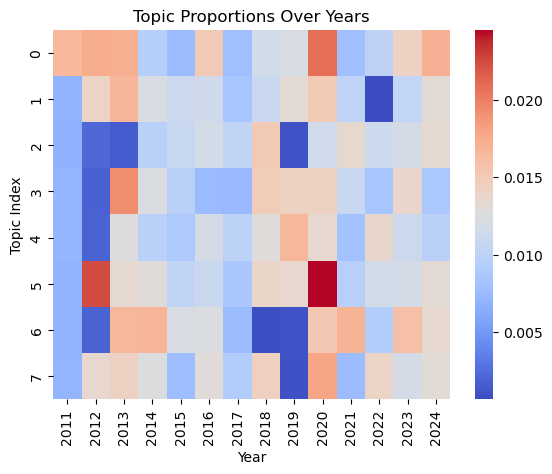

In [12]:
# Shows heat map for changes of topics proportions over the years
def plot_topic_evolution(models):
    topic_proportions = {}

    for year, model in sorted(models.items()):
        topic_proportions[year] = []
        for i in range(model.num_topics):
            topic_proportion = sum([freq for _, freq in model.show_topic(i)]) / model.num_topics
            topic_proportions[year].append(topic_proportion)

    df = pd.DataFrame(topic_proportions)
    sns.heatmap(df, cmap='coolwarm')
    plt.xlabel('Year')
    plt.ylabel('Topic Index')
    plt.title('Topic Proportions Over Years')
    plt.show()

plot_topic_evolution(models)

It can useful to track the topic term words changes year by year (ie determine which term words are common)

In [13]:
# Shows the topics for each year in term words with probabilities
def display_topics_over_time(models):
    for year, model in models.items():
        print(f"\nTopics for {year}:")
        for idx, topic in model.print_topics(num_topics=-1, num_words=10):
            print(f"Topic {idx}: {topic}")

display_topics_over_time(models)


Topics for 2011:
Topic 0: 0.024*"management" + 0.020*"team" + 0.012*"business" + 0.012*"network" + 0.012*"system" + 0.012*"breakdown" + 0.012*"response" + 0.008*"local" + 0.008*"unfortunately" + 0.008*"competency"
Topic 1: 0.006*"management" + 0.006*"team" + 0.006*"response" + 0.006*"minister" + 0.006*"network" + 0.006*"breakdown" + 0.006*"business" + 0.006*"appease" + 0.006*"system" + 0.006*"plot"
Topic 2: 0.006*"management" + 0.006*"team" + 0.006*"network" + 0.006*"response" + 0.006*"system" + 0.006*"organisation" + 0.006*"business" + 0.006*"getting" + 0.006*"head" + 0.006*"stream"
Topic 3: 0.006*"management" + 0.006*"team" + 0.006*"response" + 0.006*"system" + 0.006*"breakdown" + 0.006*"network" + 0.006*"business" + 0.006*"actor" + 0.006*"head" + 0.006*"lost"
Topic 4: 0.006*"team" + 0.006*"management" + 0.006*"business" + 0.006*"system" + 0.006*"response" + 0.006*"technocratic" + 0.006*"network" + 0.006*"breakdown" + 0.006*"current" + 0.006*"focus"
Topic 5: 0.006*"management" + 0.0

In [14]:
# Shows the words in each topic over each year without probabilities
def summarize_topic_changes(models, num_words=10):
    summary = {}

    for year, model in sorted(models.items()):
        print(f"\nYear: {year}")
        summary[year] = {idx: [word.split('*')[1].strip('"') for word in topic.split(' + ')]
                         for idx, topic in model.print_topics(num_topics=-1, num_words=num_words)}
        for idx, words in summary[year].items():
            print(f"  Topic {idx}: {words}")

    return summary

summary = summarize_topic_changes(models)


Year: 2011
  Topic 0: ['management', 'team', 'business', 'network', 'system', 'breakdown', 'response', 'local', 'unfortunately', 'competency']
  Topic 1: ['management', 'team', 'response', 'minister', 'network', 'breakdown', 'business', 'appease', 'system', 'plot']
  Topic 2: ['management', 'team', 'network', 'response', 'system', 'organisation', 'business', 'getting', 'head', 'stream']
  Topic 3: ['management', 'team', 'response', 'system', 'breakdown', 'network', 'business', 'actor', 'head', 'lost']
  Topic 4: ['team', 'management', 'business', 'system', 'response', 'technocratic', 'network', 'breakdown', 'current', 'focus']
  Topic 5: ['management', 'team', 'network', 'breakdown', 'response', 'competency', 'business', 'may', 'wonder', 'focus']
  Topic 6: ['management', 'team', 'response', 'network', 'system', 'breakdown', 'business', 'lost', 'technocratic', 'december']
  Topic 7: ['team', 'management', 'breakdown', 'response', 'network', 'lost', 'system', 'resource', 'action', 'spa

In [15]:
# Shows year on year comparison of the term words. Common words shown to see what has not changed year on year.
def compare_topics_over_years(summary):
    print("\nComparing Topics Over the Years:")
    for year1, year2 in zip(sorted(summary.keys())[:-1], sorted(summary.keys())[1:]):
        print(f"\nFrom {year1} to {year2}:")
        for topic_idx, words_year1 in summary[year1].items():
            words_year2 = summary[year2].get(topic_idx, [])
            common_words = set(words_year1) & set(words_year2)
            print(f"  Topic {topic_idx}:")
            print(f"    Common words: {common_words}")
            print(f"    Words in {year1}: {words_year1}")
            print(f"    Words in {year2}: {words_year2}")

compare_topics_over_years(summary)


Comparing Topics Over the Years:

From 2011 to 2012:
  Topic 0:
    Common words: {'system', 'network', 'breakdown'}
    Words in 2011: ['management', 'team', 'business', 'network', 'system', 'breakdown', 'response', 'local', 'unfortunately', 'competency']
    Words in 2012: ['breakdown', 'system', 'disruption', 'last', 'circle', 'work', 'authority', 'plan', 'repair', 'network']
  Topic 1:
    Common words: {'minister', 'breakdown'}
    Words in 2011: ['management', 'team', 'response', 'minister', 'network', 'breakdown', 'business', 'appease', 'system', 'plot']
    Words in 2012: ['breakdown', 'home', 'northbound', 'stuck', 'going', 'disruption', 'ventilation', 'experience', 'minister', 'city']
  Topic 2:
    Common words: set()
    Words in 2011: ['management', 'team', 'network', 'response', 'system', 'organisation', 'business', 'getting', 'head', 'stream']
    Words in 2012: ['lta', 'lui', 'maintenance', 'operator', 'coi', 'disruption', 'plan', 'ministry', 'last', 'rail']
  Topic 3:

We can see the topic terms for each year separately in visual plots. 
<br>Let us do a selection of the years to prevent clutter.

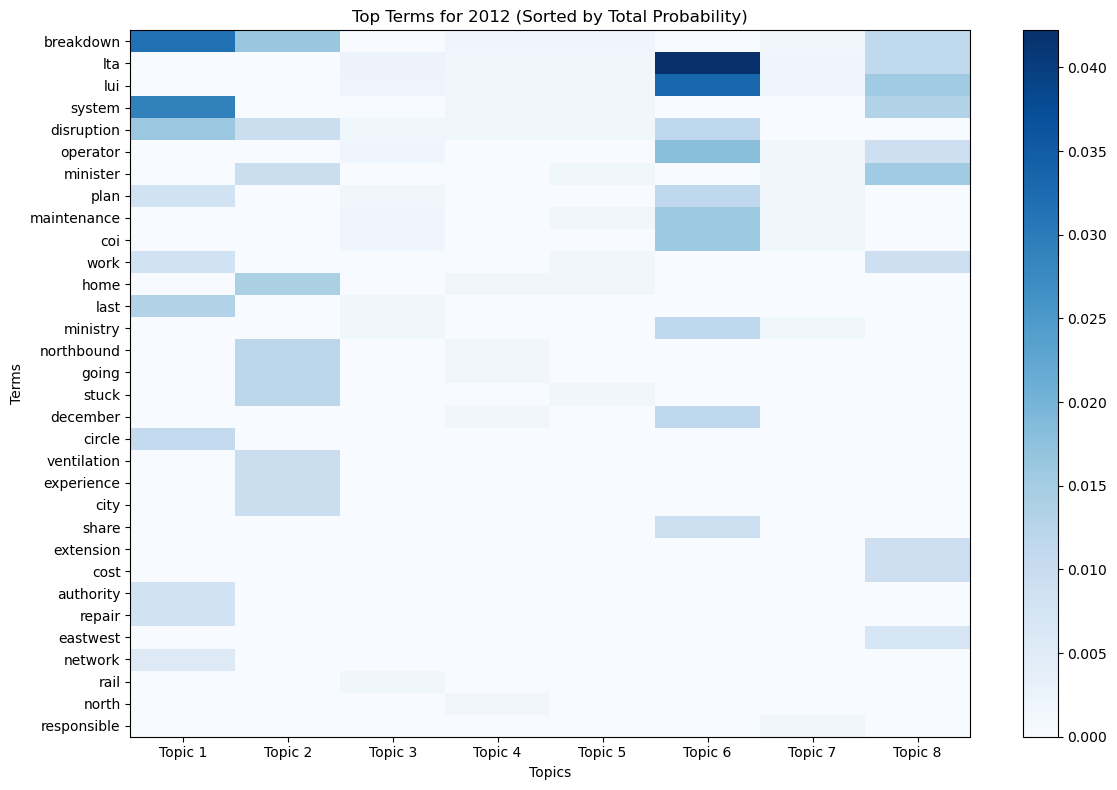

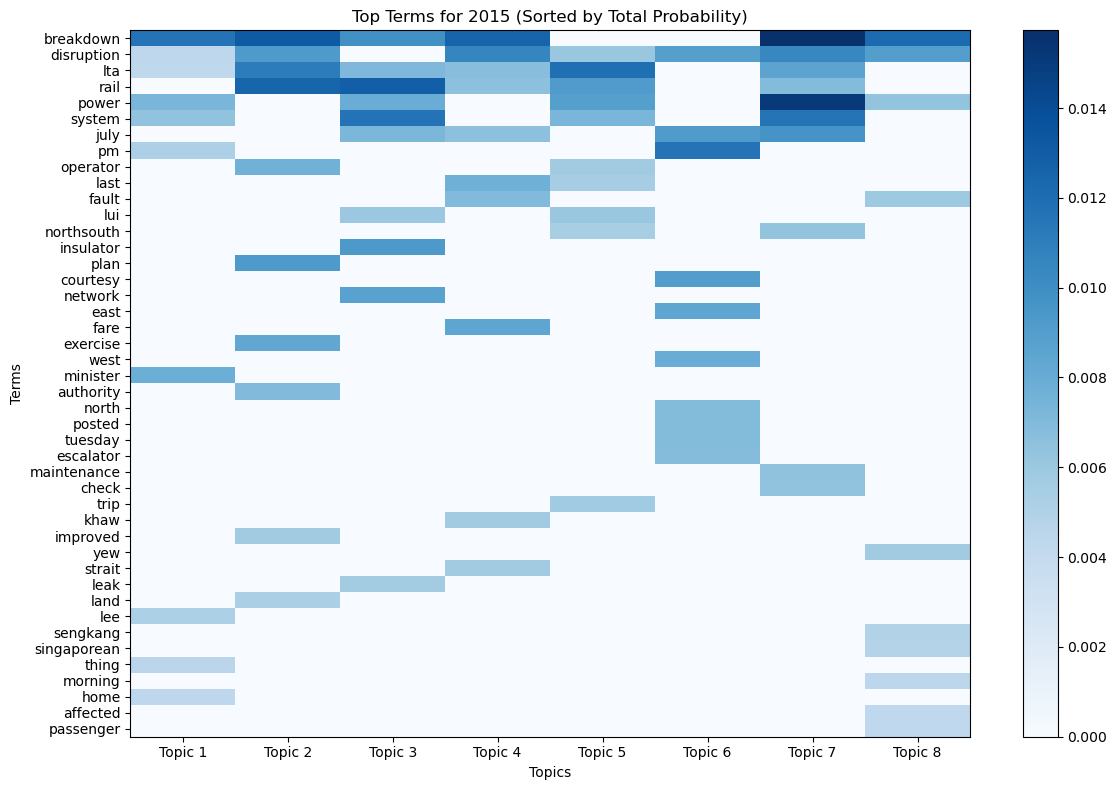

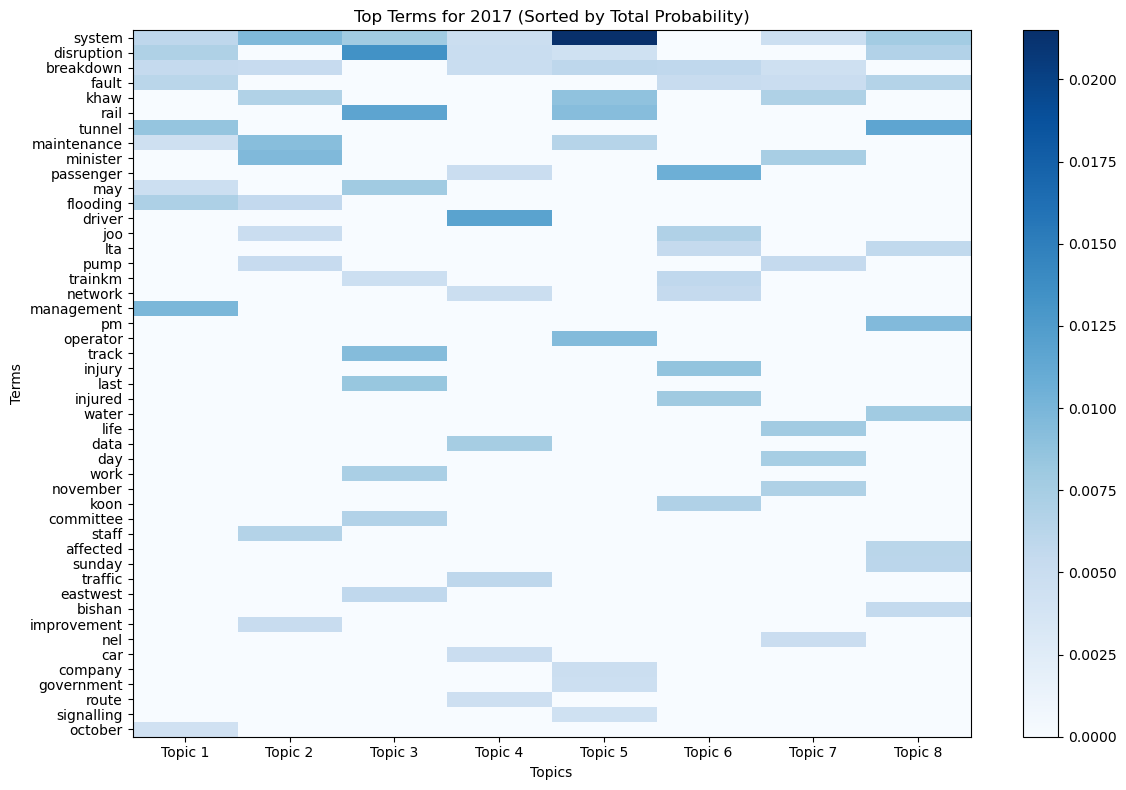

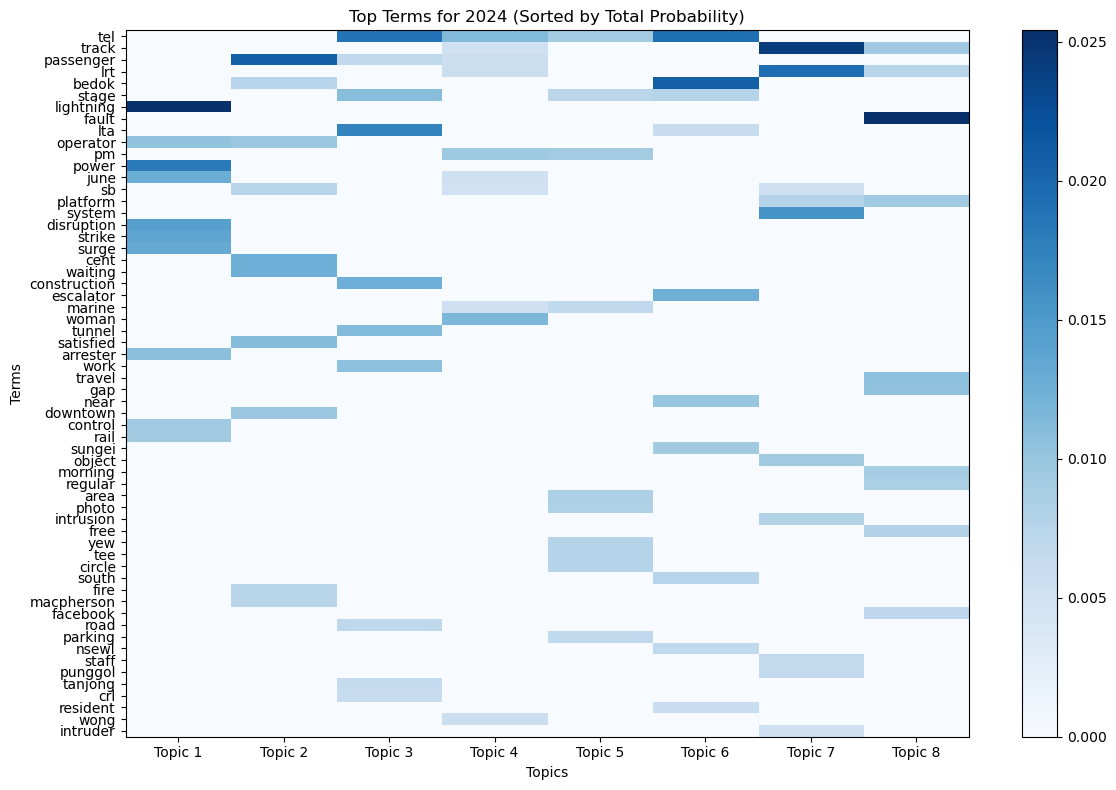

In [16]:
def plot_top_terms_for_sampled_years_sorted(models, dictionaries, sampled_years, num_topics=8):
    for year in sampled_years:
        term_probabilities = defaultdict(float)

        # Aggregate probabilities for each term across all topics
        for topic_id in range(num_topics):
            terms = models[year].show_topic(topic_id, topn=10)  # Get top 10 word terms
            for term, prob in terms:
                term_probabilities[term] += prob

        # Sort terms by their aggregated probability
        sorted_terms = sorted(term_probabilities.items(), key=lambda x: x[1], reverse=True)
        unique_terms, sorted_probs = zip(*sorted_terms)  # Separate terms and probabilities
        
        # Create the term matrix
        term_matrix = np.zeros((len(unique_terms), num_topics))

        for topic_id in range(num_topics):
            terms = models[year].show_topic(topic_id, topn=10)    # show top 10 term words for each topic to prevent clutter
            for term, prob in terms:
                term_matrix[unique_terms.index(term), topic_id] = prob

        # Plotting
        plt.figure(figsize=(12, 8))
        im = plt.imshow(term_matrix, cmap='Blues', aspect='auto')

        # Annotate the plot
        plt.yticks(range(len(unique_terms)), unique_terms)
        plt.xticks(range(num_topics), [f"Topic {i+1}" for i in range(num_topics)])
        plt.title(f"Top Terms for {year} (Sorted by Total Probability)")
        plt.xlabel("Topics")
        plt.ylabel("Terms")
        plt.colorbar(im)
        plt.tight_layout()

        # Show plot for each year
        plt.show()

sampled_years = ['2012', '2015', '2017', '2024']  # Selected years

plot_top_terms_for_sampled_years_sorted(models, dictionaries, sampled_years, num_topics=8)

### Show summary of topics over each year visually

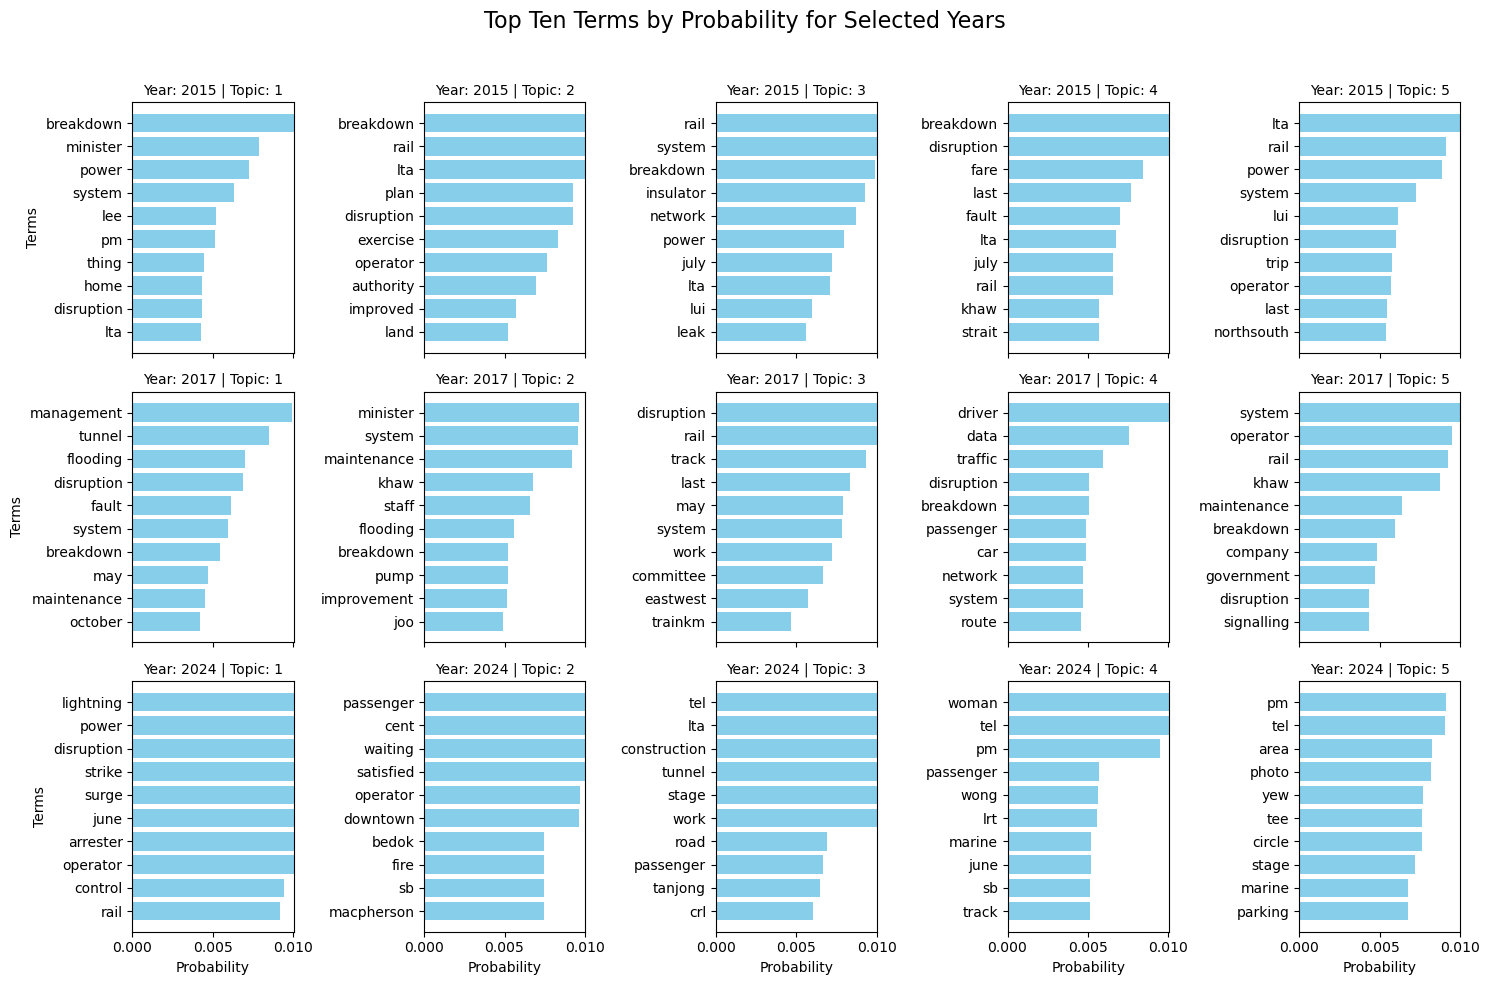

In [27]:
# Note that topn is the top number n of word terms which can be adjusted
def plot_top_terms_for_years(models, selected_years, num_topics=5, topn=10):
    fig, axes = plt.subplots(len(selected_years), num_topics, figsize=(15, 10), sharex=True)
    fig.suptitle('Top Ten Terms by Probability for Selected Years', fontsize=16)

    for i, year in enumerate(selected_years):
        for j in range(num_topics):
            terms = models[year].show_topic(j, topn=topn)  # Get top `topn` terms for topic j
            terms, probs = zip(*terms)  # Separate terms and probabilities
            
            axes[i, j].barh(terms, probs, color='skyblue')
            axes[i, j].set_xlim(0, max(probs) * 1.1)
            axes[i, j].invert_yaxis()  # Most probable term at the top
            axes[i, j].set_title(f'Year: {year} | Topic: {j+1}', fontsize=10)

            if j == 0:
                axes[i, j].set_ylabel('Terms')

        if i == len(selected_years) - 1:
            for ax in axes[i]:
                ax.set_xlabel('Probability')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Customized list of years for plotting
selected_years = ['2015', '2017', '2024']  # Selected years because too messy to show all years
plot_top_terms_for_years(models, selected_years, num_topics=5, topn=10) # Show 5 topics only to prvent clutter

### Top 10 terms for each year
Simplified to analyze by top number of probable terms than to analyze by topics.

We show the actual terms in words per year here.

In [18]:
# Note that topn is the top number n of terms which can be adjusted
def get_top_terms_over_years(models, topn=10):
    top_terms_over_years = defaultdict(list)

    # Iterate over each year and model
    for year, model in sorted(models.items()):
        term_probabilities = defaultdict(float)

        # Aggregate term probabilities across all topics for the year
        for topic_id in range(len(model.show_topics())):
            terms = model.show_topic(topic_id, topn=len(model.id2word))
            for term, prob in terms:
                term_probabilities[term] += prob

        # Sort terms by their aggregated probability and select the top 10
        sorted_terms = sorted(term_probabilities.items(), key=lambda x: x[1], reverse=True)
        top_terms = sorted_terms[:topn]
        top_terms_over_years[year] = top_terms
    
    return top_terms_over_years

def display_top_terms_over_years(top_terms_over_years):
    for year, terms in sorted(top_terms_over_years.items()):
        print(f"\nTop {len(terms)} terms for {year}:")
        for term, prob in terms:
            print(f"{term}: {prob:.4f}")


top_terms_over_years = get_top_terms_over_years(models, topn=10)
display_top_terms_over_years(top_terms_over_years)


Top 10 terms for 2011:
management: 0.0644
team: 0.0600
response: 0.0516
breakdown: 0.0516
system: 0.0516
network: 0.0516
business: 0.0516
head: 0.0474
plot: 0.0474
current: 0.0474

Top 10 terms for 2012:
breakdown: 0.0678
lta: 0.0635
lui: 0.0612
system: 0.0555
disruption: 0.0497
minister: 0.0384
operator: 0.0335
work: 0.0325
maintenance: 0.0301
december: 0.0294

Top 10 terms for 2013:
disruption: 0.0593
affected: 0.0576
fault: 0.0542
system: 0.0513
operator: 0.0492
passenger: 0.0485
pm: 0.0484
lta: 0.0473
sb: 0.0456
nel: 0.0451

Top 10 terms for 2014:
disruption: 0.0665
operator: 0.0601
system: 0.0563
rail: 0.0481
lta: 0.0423
breakdown: 0.0361
track: 0.0350
work: 0.0330
affected: 0.0284
current: 0.0284

Top 10 terms for 2015:
breakdown: 0.0849
disruption: 0.0629
power: 0.0557
system: 0.0542
lta: 0.0542
rail: 0.0525
july: 0.0491
operator: 0.0312
northsouth: 0.0309
lui: 0.0298

Top 10 terms for 2016:
breakdown: 0.0517
system: 0.0500
lta: 0.0444
rail: 0.0440
disruption: 0.0434
fault: 0.0

We plot into charts for easy visualization for all years.

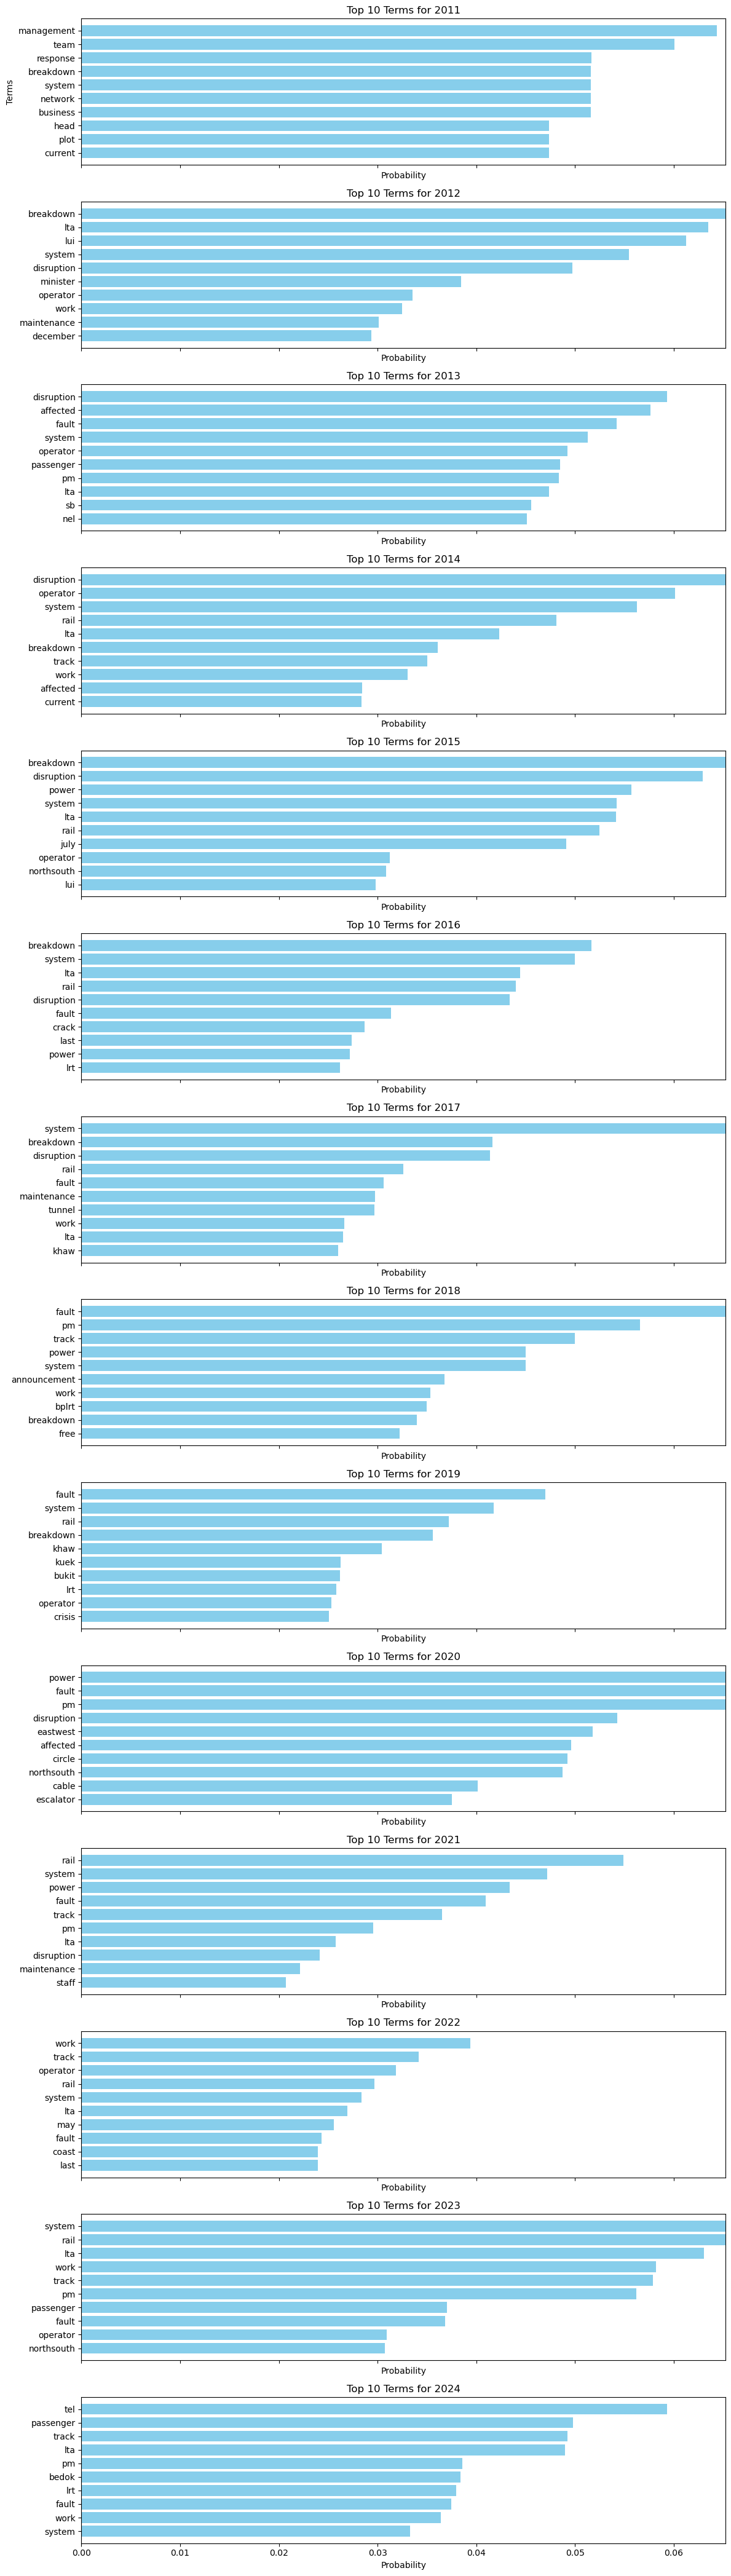

In [19]:
def plot_top_terms_over_years(top_terms_over_years, topn=10):
    num_years = len(top_terms_over_years)
    fig, axes = plt.subplots(num_years, 1, figsize=(12, num_years * 3), sharex=True)

    if num_years == 1:
        axes = [axes]  # Ensure axes is iterable even if there's only one subplot

    for i, (year, terms) in enumerate(sorted(top_terms_over_years.items())):
        if not terms:
            continue

        terms, probs = zip(*terms)  # Unpack terms and probabilities
        
        axes[i].barh(terms, probs, color='skyblue')
        axes[i].set_xlim(0, max(probs) * 1.1)  # Set x-axis limit slightly higher than max probability
        axes[i].invert_yaxis()  # Invert y-axis so that the highest probability term is at the top
        axes[i].set_title(f'Top {topn} Terms for {year}')
        axes[i].set_xlabel('Probability')
        
        if i == 0:
            axes[i].set_ylabel('Terms')

    plt.tight_layout()
    plt.show()

top_terms_over_years = get_top_terms_over_years(models, topn=10)
plot_top_terms_over_years(top_terms_over_years, topn=10)

We want to see the top terms for only a few selected years for presentation purposes, and not for all years.

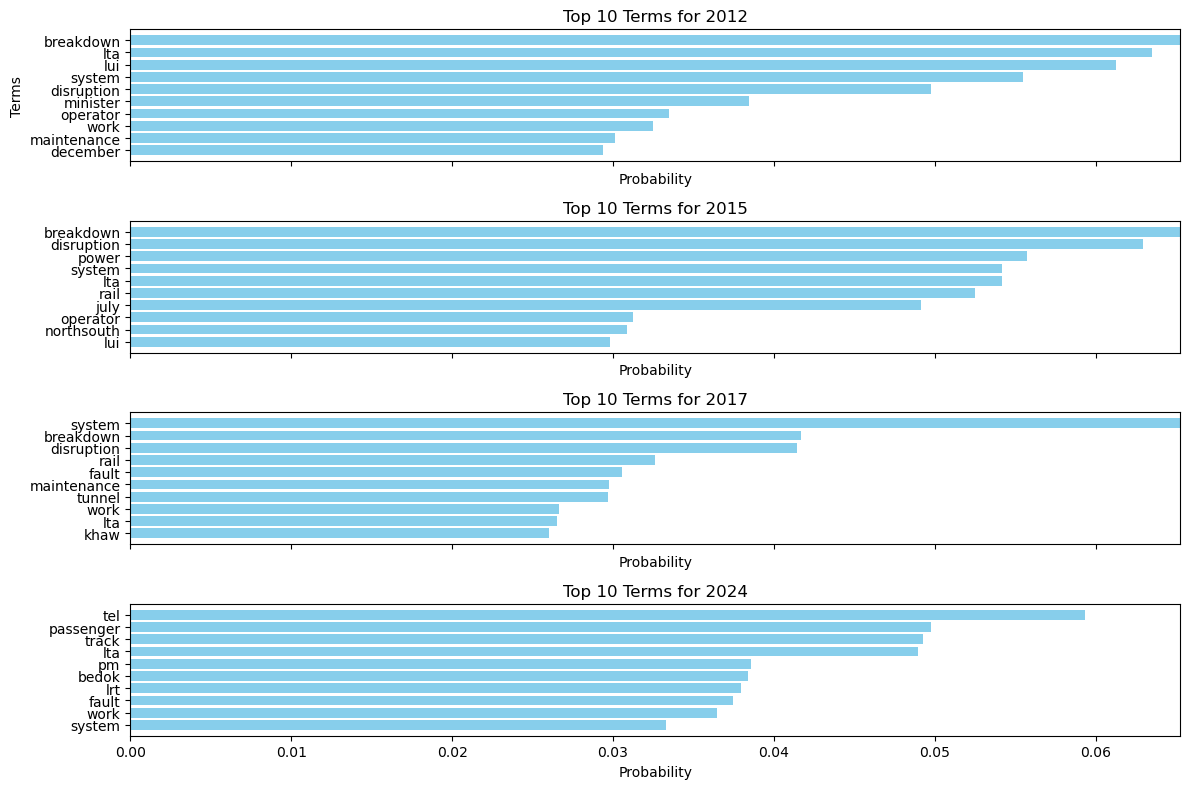

In [20]:
def plot_top_terms_over_selected_years(top_terms_over_years, selected_years, topn=10):
    num_years = len(selected_years)
    fig, axes = plt.subplots(num_years, 1, figsize=(12, 8), sharex=True)
    
    if num_years == 1:
        axes = [axes]  # Ensure axes is iterable even if there's only one subplot

    for i, year in enumerate(selected_years):
        terms = top_terms_over_years.get(year, [])
        if not terms:
            continue

        terms, probs = zip(*terms)
        
        axes[i].barh(terms, probs, color='skyblue')
        axes[i].set_xlim(0, max(probs) * 1.1)
        axes[i].invert_yaxis()  # Most probable term at the top
        axes[i].set_title(f'Top {topn} Terms for {year}')
        axes[i].set_xlabel('Probability')
        
        if i == 0:
            axes[i].set_ylabel('Terms')

    plt.tight_layout()
    plt.show()

selected_years = ['2012', '2015', '2017', '2024']  # Selected years
plot_top_terms_over_selected_years(top_terms_over_years, selected_years, topn=10)

We shall look at the top 5 probable terms for each year and see how the terms change in probability over the years.

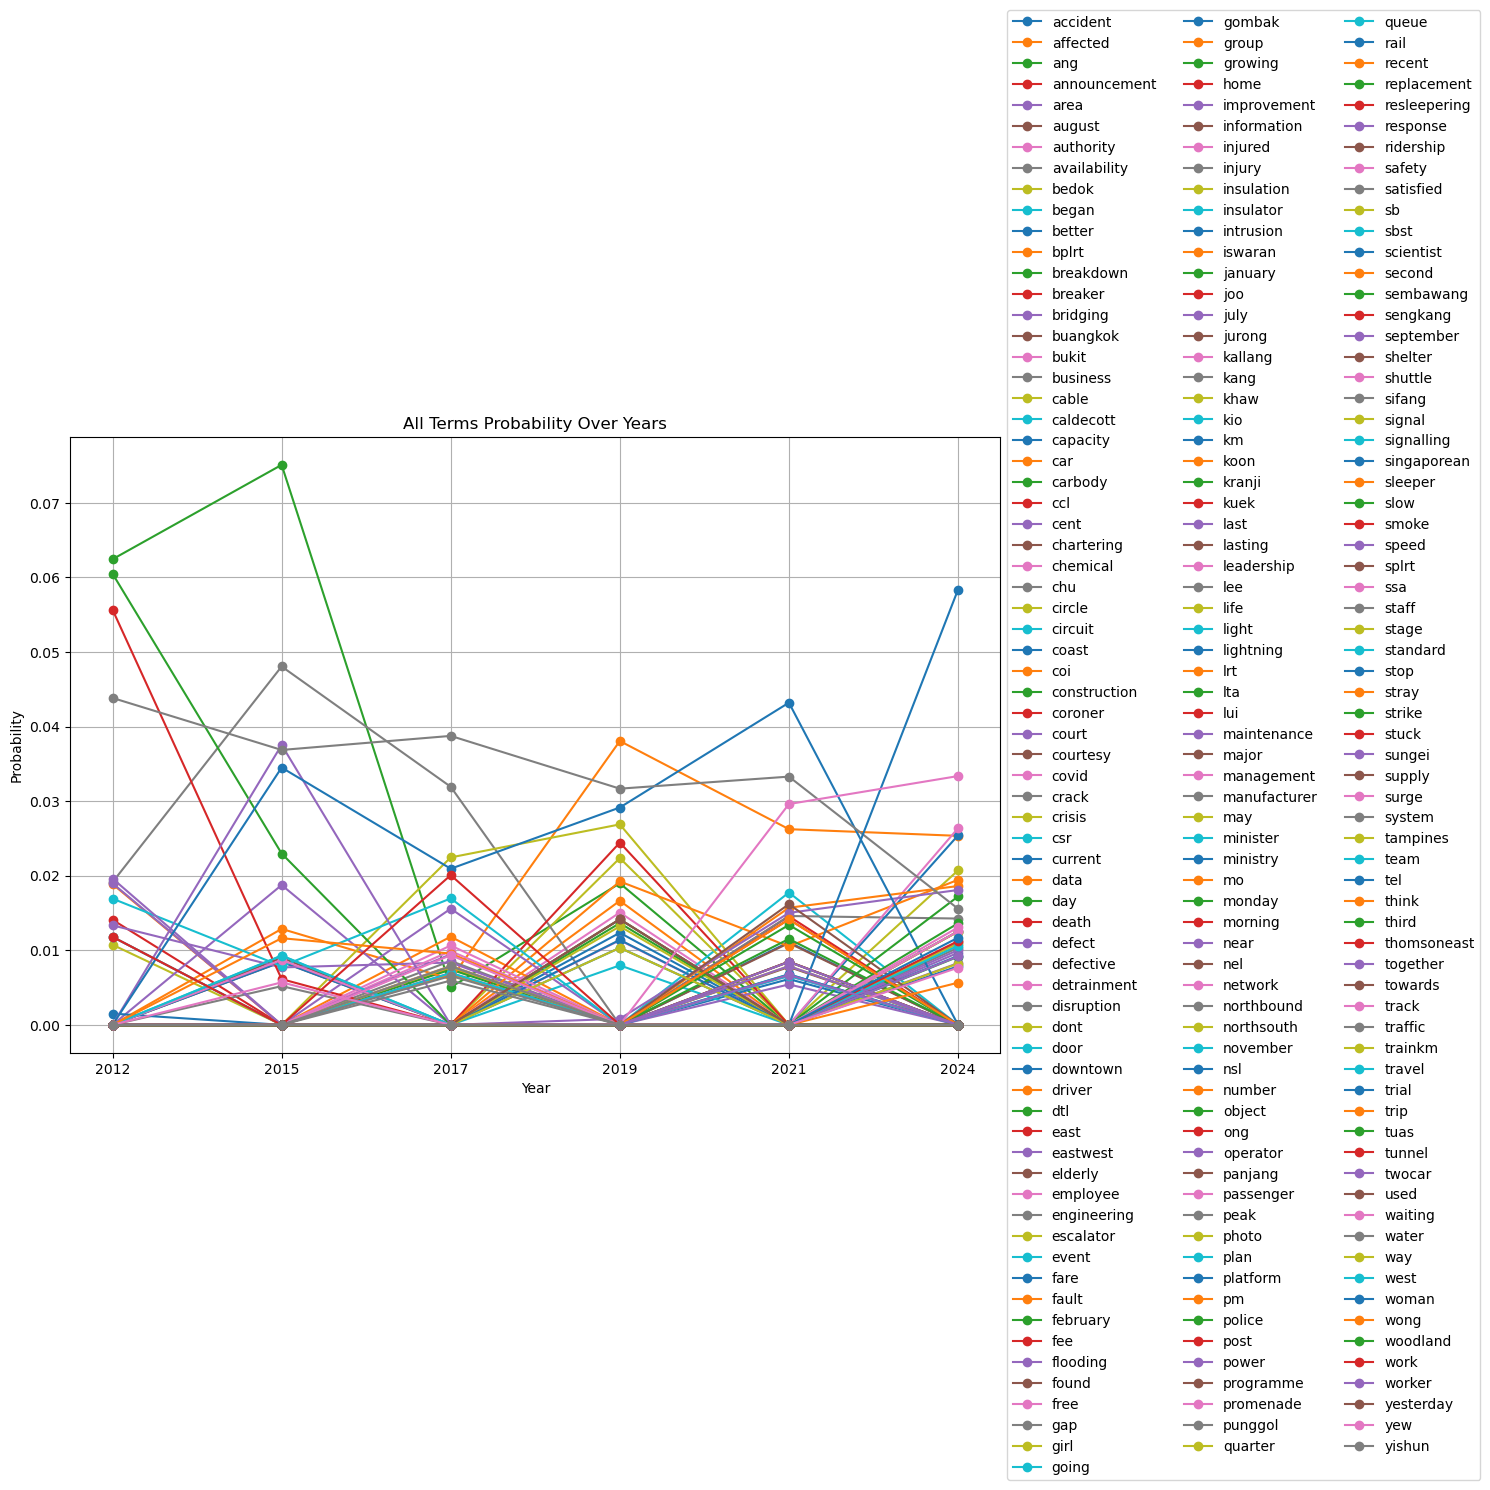

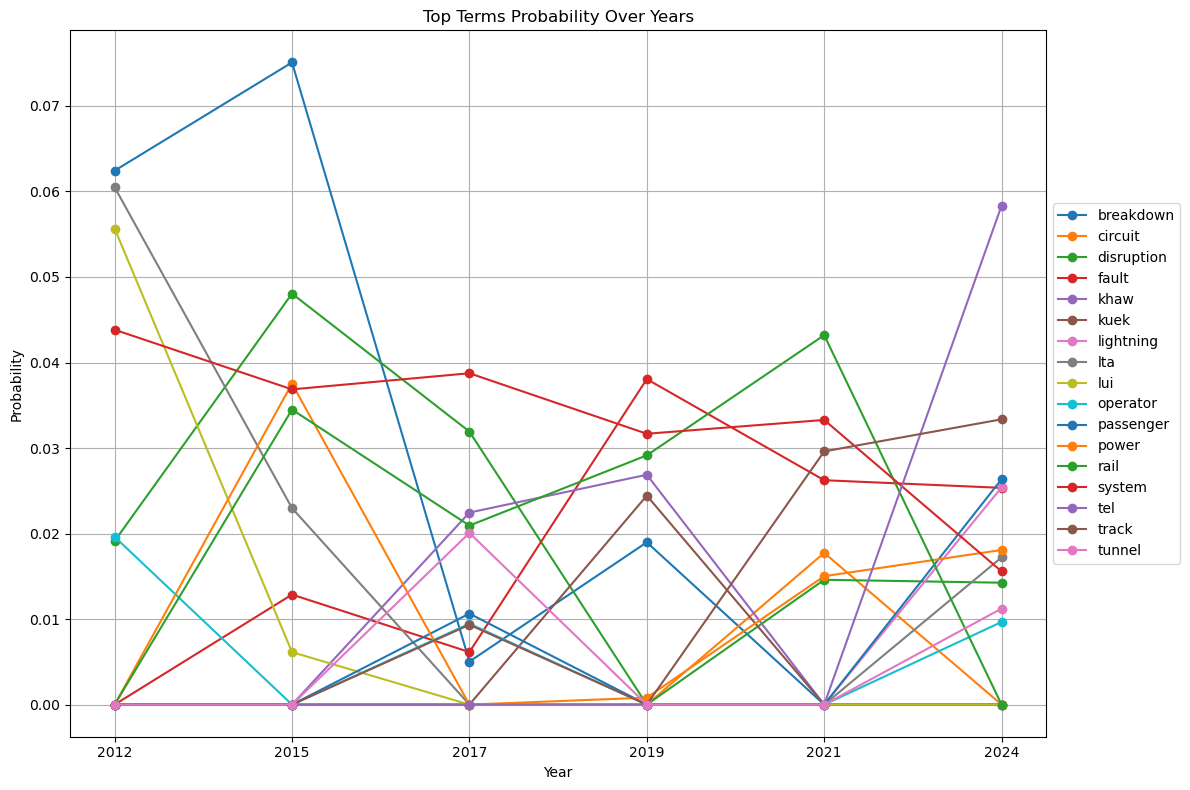

In [21]:
# Function to get top terms over years
def get_top_terms_over_years(models, topn=10, include_all_terms=False):
    term_probabilities = defaultdict(lambda: defaultdict(float))
    top_terms_over_years = defaultdict(list)

    for year, model in sorted(models.items()):
        year_term_probabilities = defaultdict(float)

        # Aggregate term probabilities across all topics for the year
        for topic_id in range(len(model.show_topics())):
            terms = model.show_topic(topic_id, topn=topn)  # Get top `topn` terms
            for term, prob in terms:
                term_probabilities[term][year] += prob
                year_term_probabilities[term] += prob

        if not include_all_terms:
            # Sort terms by their aggregated probability and select the top `topn`
            sorted_terms = sorted(year_term_probabilities.items(), key=lambda x: x[1], reverse=True)
            top_terms_over_years[year] = sorted_terms[:topn]
        else:
            top_terms_over_years[year] = year_term_probabilities.items()
    
    return term_probabilities, top_terms_over_years

# Function to plot term changes over years
def plot_term_changes_over_years(term_probabilities, top_terms_over_years, selected_years, topn=10, plot_all_terms=False, ncol=2):
    terms_to_plot = set()

    if plot_all_terms:
        for year in selected_years:
            terms_to_plot.update(term_probabilities.keys())
    else:
        for year in selected_years:
            terms_to_plot.update([term for term, _ in top_terms_over_years.get(year, [])])

    terms_to_plot = sorted(terms_to_plot)

    fig, ax = plt.subplots(figsize=(12, 8))

    for term in terms_to_plot:
        term_probs = [term_probabilities[term].get(year, 0) for year in selected_years]
        ax.plot(selected_years, term_probs, marker='o', label=term)

    ax.set_xlabel('Year')
    ax.set_ylabel('Probability')
    ax.set_title(f'{"Top" if not plot_all_terms else "All"} Terms Probability Over Years')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=ncol)
    ax.grid(True)

    plt.tight_layout()
    plt.show()

selected_years = ['2012', '2015', '2017', '2019', '2021', '2024']  # Selected years

# Select the top n number of terms for each year. Choose 5 here to reduce clutter.
topn = 5

# Generate and plot all terms for each year (eg all terms for year 1, all terms for year 2, all terms for year 3, etc.)
term_probabilities, top_terms_over_years_all = get_top_terms_over_years(models, topn=topn, include_all_terms=True)
plot_term_changes_over_years(term_probabilities, top_terms_over_years_all, selected_years, topn=topn, plot_all_terms=True, ncol=3)


# Generate and plot all top n terms for each year (eg top n for year 1, top n for year 2, top n for year 3, etc.)
term_probabilities, top_terms_over_years = get_top_terms_over_years(models, topn=topn, include_all_terms=False)
plot_term_changes_over_years(term_probabilities, top_terms_over_years, selected_years, topn=topn, plot_all_terms=False, ncol=1)

Print total list top 10 term words for each year to see if there are any distinct category groupings among the terms.
<br> eg location, time of day, type of incident, etc.

In [22]:
def print_top_terms_across_years(models, topn=10, num_columns=5):
    def print_in_columns(items, num_columns):
        """ Helper function to print items in multiple columns """
        num_rows = (len(items) + num_columns - 1) // num_columns
        for row in range(num_rows):
            row_items = [items[row + i * num_rows] if row + i * num_rows < len(items) else "" for i in range(num_columns)]
            print(" | ".join(f"{item: <30}" for item in row_items))

    # Get top terms over years
    _, top_terms_over_years = get_top_terms_over_years(models, topn=topn, include_all_terms=True)
   
    top_terms = []
    for year, terms in top_terms_over_years.items():
        for term, _ in terms:  # Extract only the term names
            if term not in top_terms:  # Avoid duplicates
                top_terms.append(term)

    print(f"Top terms across all years (displayed in {num_columns} columns):")
    print_in_columns(top_terms, num_columns)

print_top_terms_across_years(models, topn=10, num_columns=5)

Top terms across all years (displayed in 5 columns):
management                     | downtime                       | courtesy                       | engineering                    | coil                          
team                           | power                          | east                           | neo                            | together                      
business                       | disrupted                      | west                           | direction                      | girl                          
network                        | woodland                       | posted                         | sembawang                      | began                         
system                         | yishun                         | tuesday                        | regular                        | stop                          
breakdown                      | evening                        | escalator                      | september                      | 

From the list of terms, we can custom create sets of term words ie 'term_sets' and analyze separately how these sets of terms change over time.


Plotting set 1 with terms: ['night', 'day']


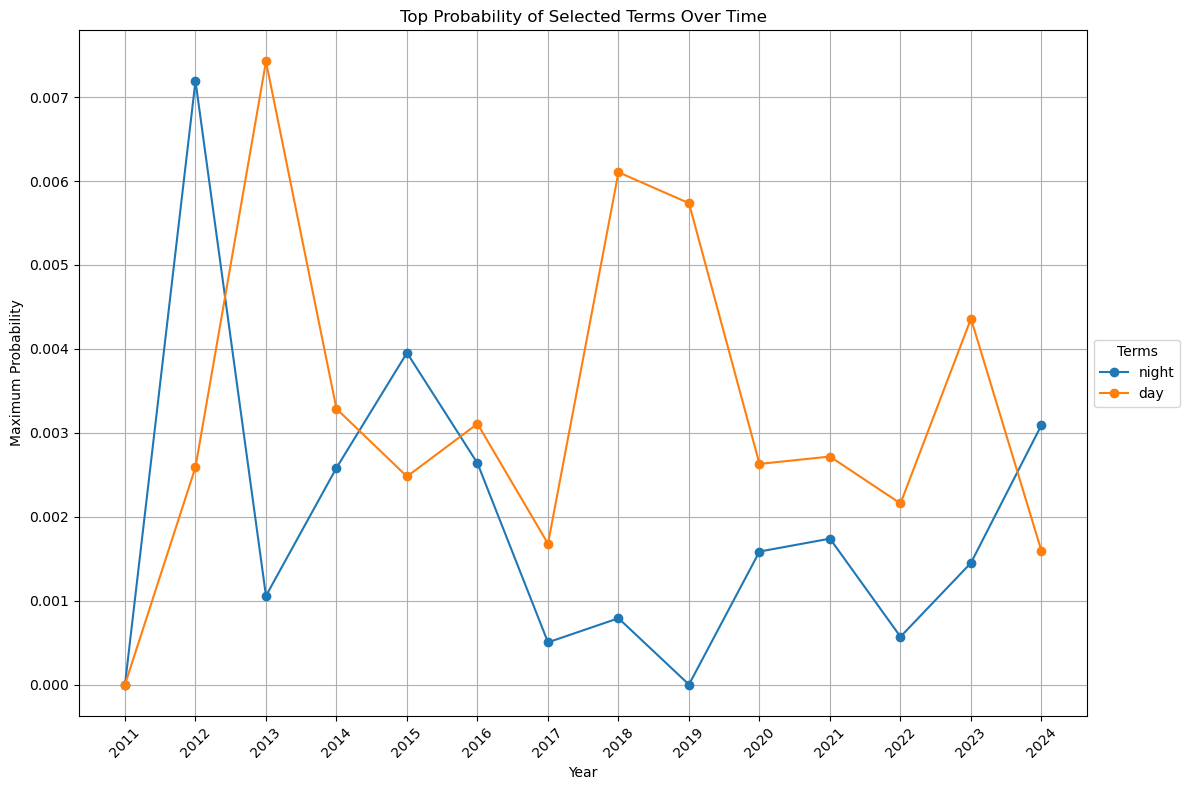


Plotting set 2 with terms: ['management', 'construction', 'ceo', 'government', 'company', 'minister']


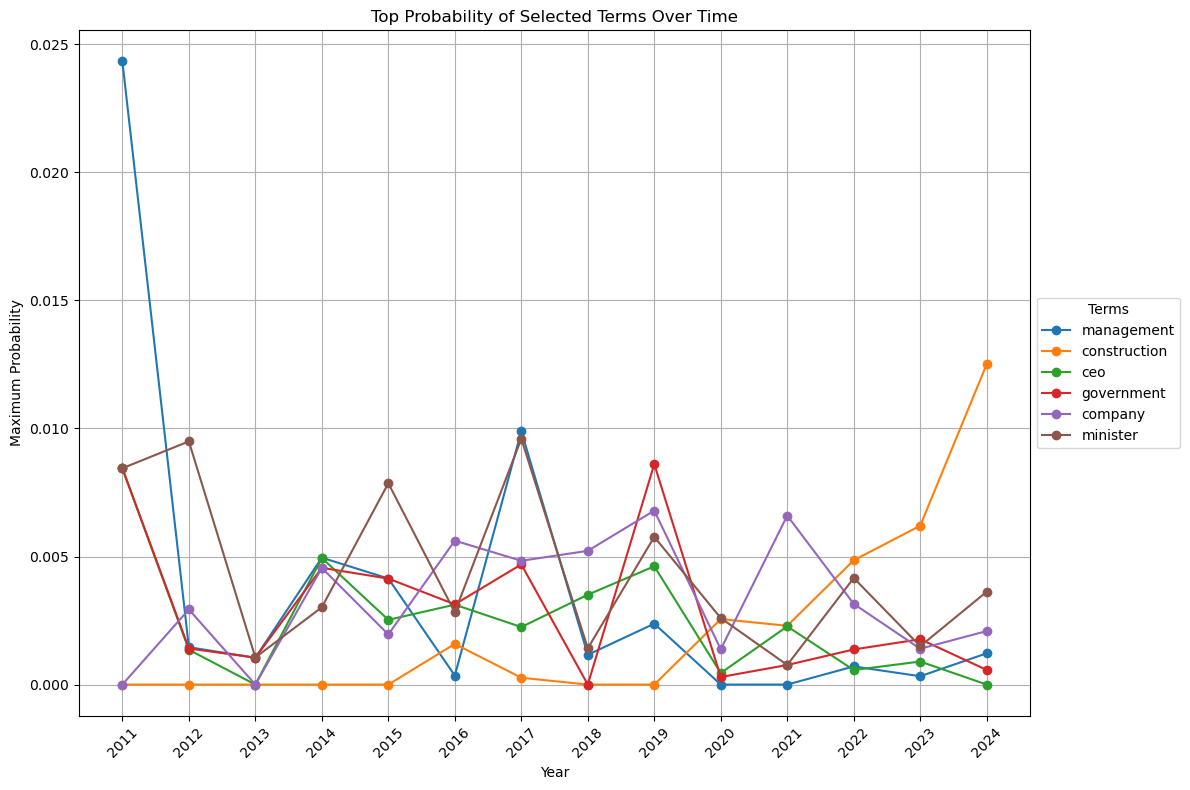


Plotting set 3 with terms: ['east', 'north', 'south', 'west', 'northsouth', 'eastwest', 'circle', 'city', 'nel', 'lrt']


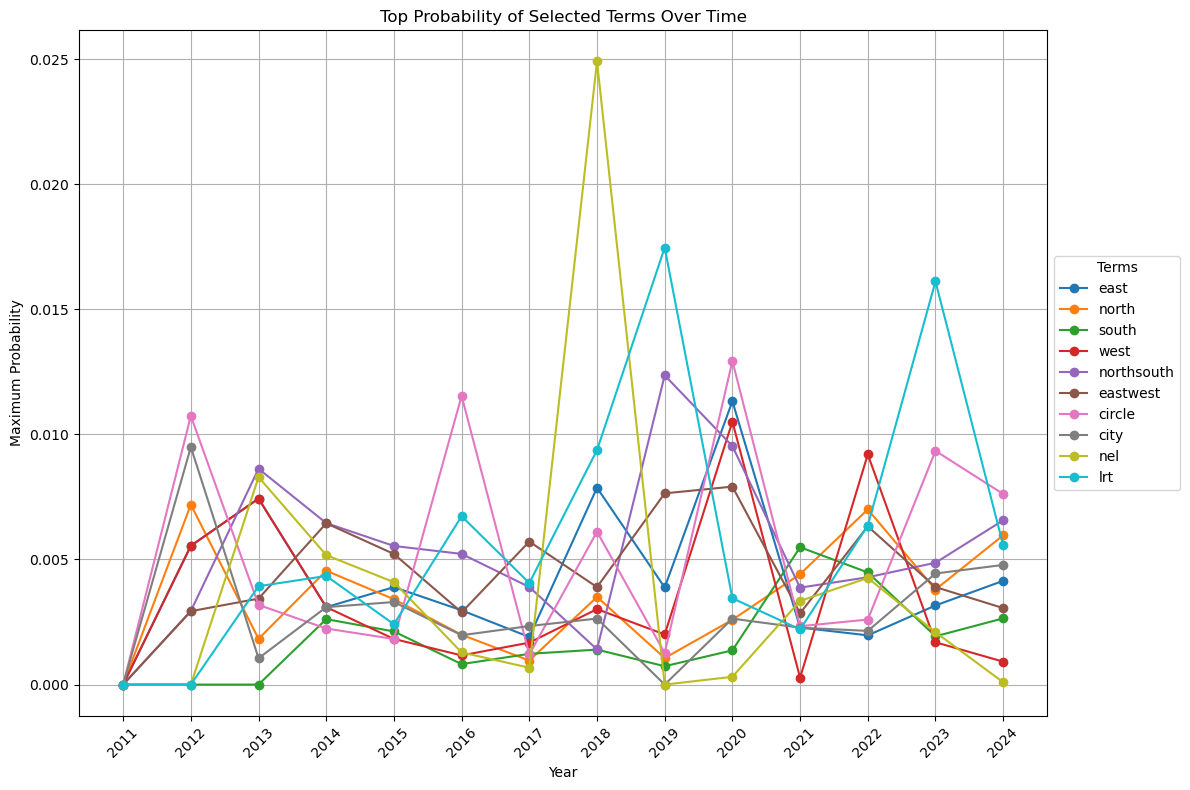


Plotting set 4 with terms: ['tuas', 'joo', 'bedok', 'harbourfront', 'kranji', 'jurong', 'bp', 'marina', 'punggol']


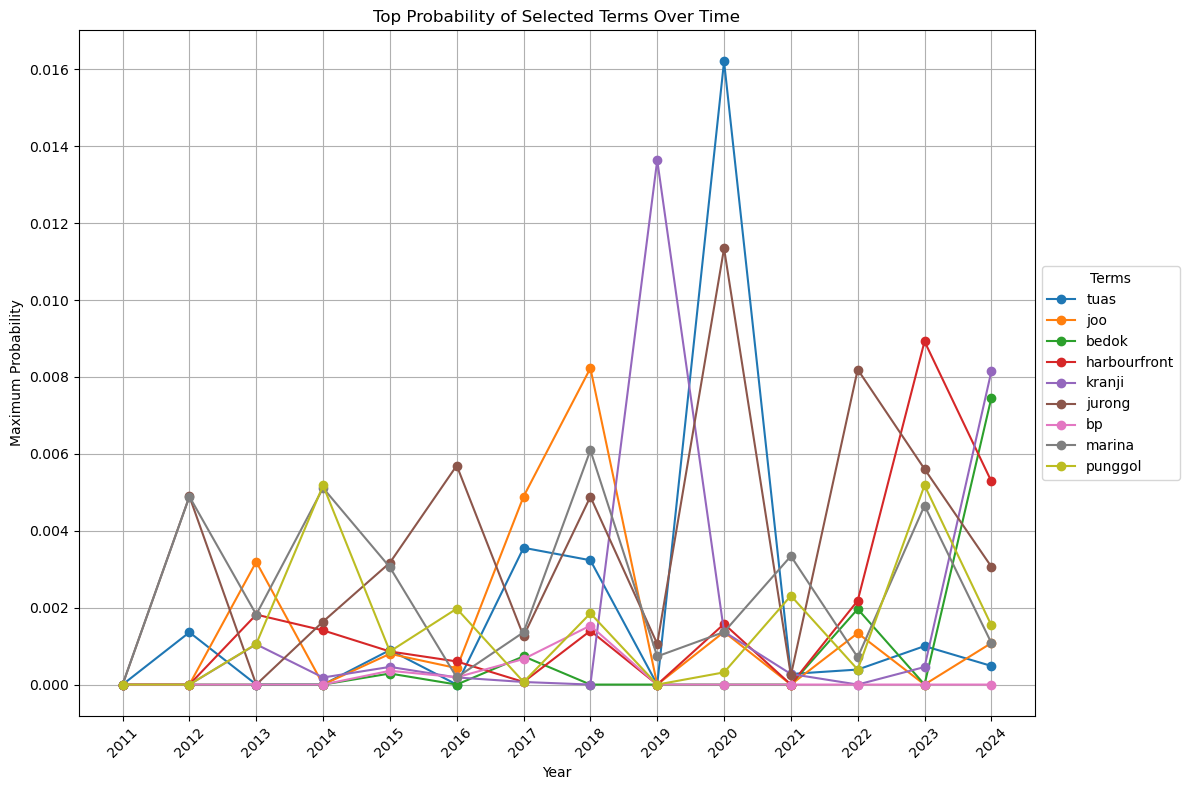


Plotting set 5 with terms: ['breakdown', 'disruption', 'fault', 'maintenance', 'accident', 'flooding', 'lightning', 'pump', 'arrestor', 'power']


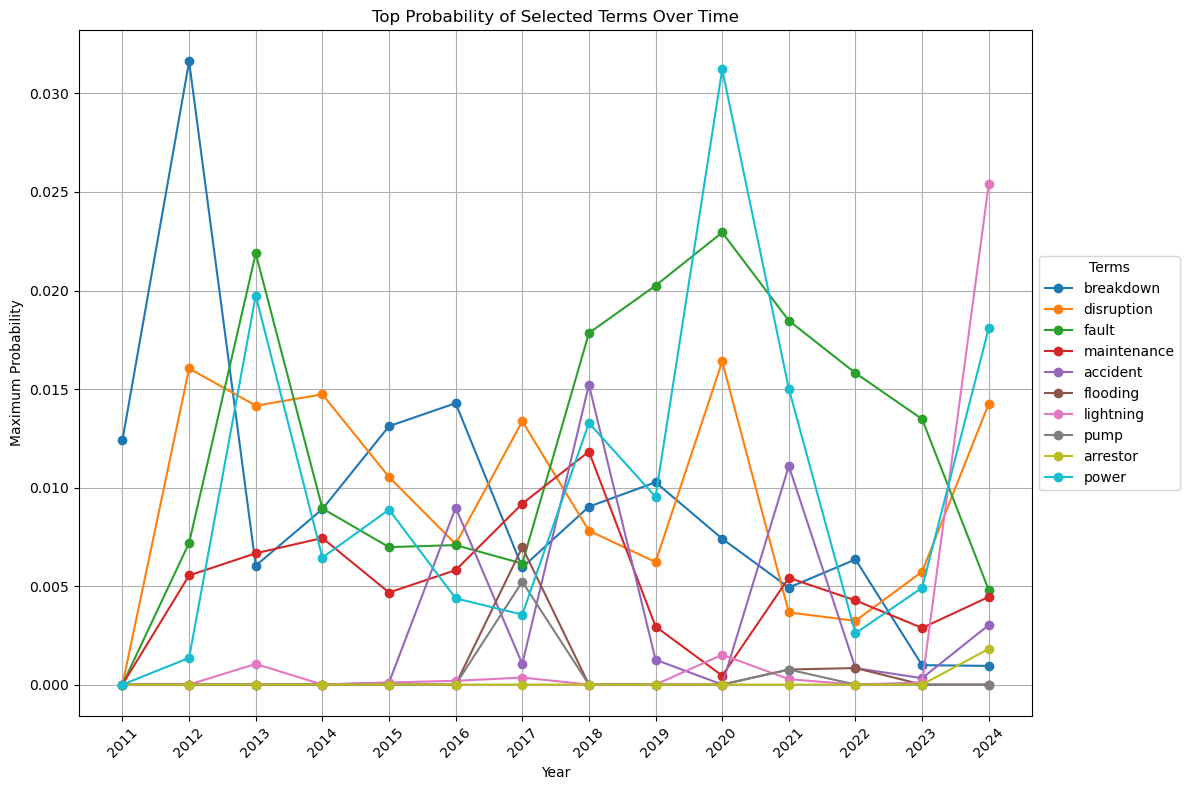


Plotting set 6 with terms: ['may', 'june', 'november', 'december']


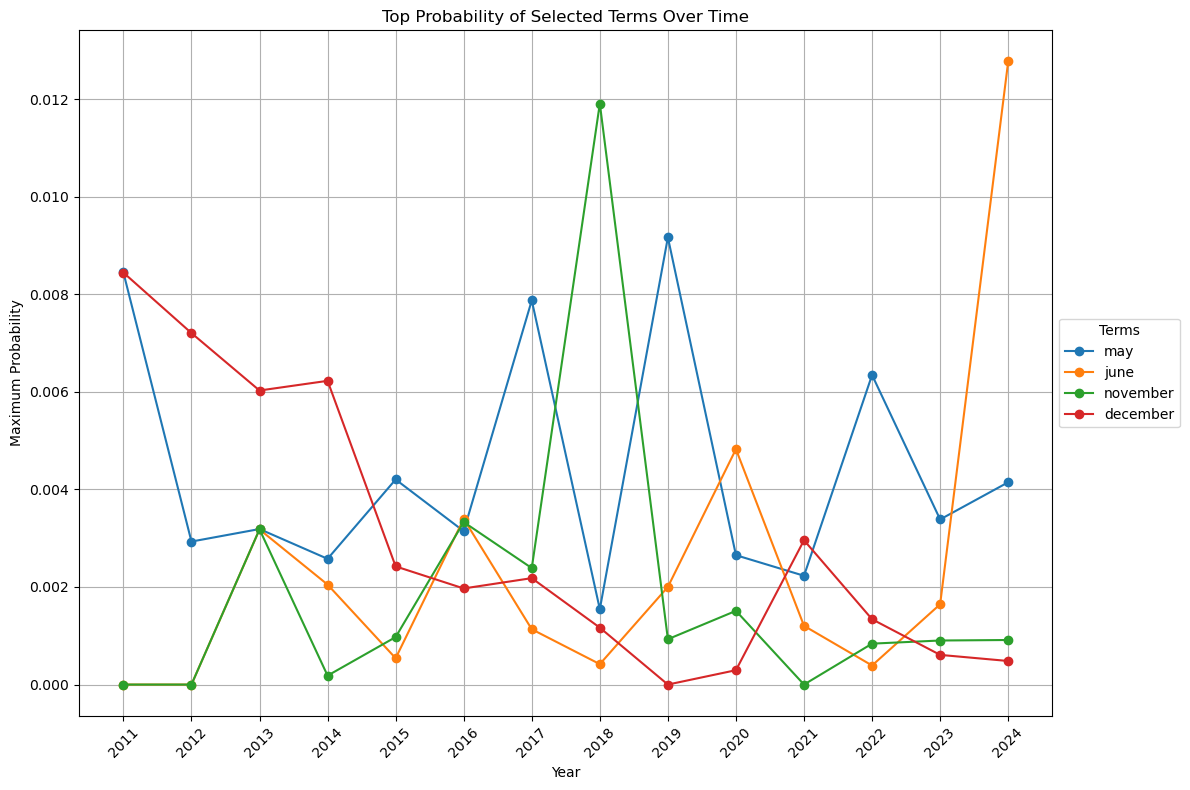

In [28]:
def get_term_probabilities_over_years(models, selected_terms, num_topics=5):
    term_probabilities = defaultdict(lambda: defaultdict(float))

    for year, model in sorted(models.items()):
        for topic_id in range(num_topics):
            terms = dict(model.show_topic(topic_id, topn=len(models[year].id2word)))
            for term in selected_terms:
                if term in terms:
                    term_probabilities[term][year] = max(term_probabilities[term][year], terms[term])

    return term_probabilities

def plot_term_probabilities_over_years(term_probabilities, selected_years, selected_terms, ncol=2):
    # Plotting
    plt.figure(figsize=(12, 8))
    for term in selected_terms:
        probs = [term_probabilities[term].get(year, 0) for year in selected_years]
        plt.plot(selected_years, probs, marker='o', label=term)

    plt.xlabel('Year')
    plt.ylabel('Maximum Probability')
    plt.title('Top Probability of Selected Terms Over Time')
    plt.legend(title='Terms', loc='center left', bbox_to_anchor=(1, 0.5), ncol=ncol)
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_multiple_term_sets(models, term_sets, num_topics=5, ncol=1):
    selected_years = sorted(models.keys())  # Ensure consistent ordering of years

    for idx, selected_terms in enumerate(term_sets):
        print(f"\nPlotting set {idx + 1} with terms: {selected_terms}")
        term_probabilities = get_term_probabilities_over_years(models, selected_terms, num_topics=num_topics)
        plot_term_probabilities_over_years(term_probabilities, selected_years, selected_terms, ncol=ncol)

# Customize term word sets
term_sets = [
    ['night', 'day'],   # Set by time of day
    ['management', 'construction', 'ceo', 'government', 'company', 'minister'],  # Set by human or organizational related
    ['east', 'north', 'south', 'west', "northsouth","eastwest", 'circle', 'city', 'nel', 'lrt'],  # Set by large regions or system boundaries
    ['tuas', 'joo', 'bedok', 'harbourfront', 'kranji', 'jurong', 'bp', 'marina', 'punggol'],  # Set by specific town estates
    ['breakdown', 'disruption', 'fault', 'maintenance', 'accident', 'flooding', 'lightning', 'pump', 'arrestor','power'],  # Set by description of incident
    ['may','june','november', 'december']  # Set by half yearly months
]

plot_multiple_term_sets(models, term_sets, num_topics=5, ncol=1)

## 6. Presentation and Final Project Portfolio

## Summary and Conclusions
In this notebook, we explored the use case of applying Dynamic Topic Modelling on Singapore MRT breakdown or reliability data from online news articles.
<br>We analyze the changes in topics over several years of historical data and identify the trends and factors that contribute to train reliability.
<br> Knowing the key areas will allow troubleshooting efforts or preventive maintenance to be more focused, hence spend less resources and improve productivity.

### Key Findings (Data from 2011 to 2024)
- Nov-Dec topics are getting less prevalent than May-Jun
- LRT, Kranji, Bedok and Harborfront stations has been on the rise of topics intensity since 2022
- Less breakdown incidents in recent years but higher faults detected
- Increasing topics related to ‘night’ in recent years up to 2024

### Recommendations for Future Data Analysis Work
- More detailed corpus may be used to determine the root cause of the faults and breakdowns.
<br>For example, engineering incident reports on the failure modes, detailed journal articles on the composition of train failure components and other reliability technical papers.
- Further analysis of the sentiments or other feedback from commuters can be conducted at 'high-risk' stations (eg Kranji, Bedok and Harborfront) can caputure further insights.

### Limitations
Dynamic Topic Modelling (DTM) is not a predictive model, but it serves to understand any emergent trends or topics that may be gaining traction eg areas to focus for future improvements.
<br>Some other limitations:
- Interpretability: The topics generated by DTM can be difficult to interpret, this can make it challenging to extract meaningful insights from the results
- Model Stability: The topics generated by DTM can sometimes be unstable, with different runs of the model producing slightly different topics. This lack of stability can make it difficult to reproduce results consistently
- Time Dependency: DTM assumes that topics evolve smoothly over time, which may not always be the case in real-world data where abrupt changes in topics can occur

### Acknowledgments
I would like to thank Ms Lim Ai Huey and other Nanyang Polytechnic instructors for guidance.
This project was also done in partnership with Wen Qiyuan.

Thank you for reviewing this notebook. If you have any questions or need further information, please feel free to reach out. [bryanchew@gmail.com](mailto:bryanchew@gmail.com)

---

*End of Notebook*